In [2]:
import os
import re
import random
import torch
import glob
import numpy as np
import gc
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image, ImageDraw

# Configs
diff_threshold = 35        # Mean grayscale difference threshold.
max_inpaint_attempts = 10   # Maximum inpainting tries per ROI (batch size).
max_roi_attempts = 3       # Maximum ROI re-selections if needed.

# Mapping for target keys and prompts.
targets = {
    "sphere": "single metallic sphere floating, a perfectly uniform, solid metallic sphere with a smooth, mirror-like reflective surface and no visible textures or patterns",
    "tictac": "a smooth, white, capsule-shaped object with rounded edges and a clean, uniform surface"
}

# Class mapping for YOLO annotations: sphere->0, tictac->1.
class_mapping = {"sphere": 0, "tictac": 1}

# Input directory with images.
input_dir = "mars_images/1200x874"
image_paths = glob.glob(os.path.join(input_dir, "*.jpg"))

# Create output directories with the new generic folder structure.
parent_dir = os.path.dirname(input_dir)
output_parent = os.path.join(parent_dir, "images")
os.makedirs(output_parent, exist_ok=True)

img_dir = os.path.join(output_parent, "img")
os.makedirs(img_dir, exist_ok=True)

mask_dir = os.path.join(output_parent, "mask")
os.makedirs(mask_dir, exist_ok=True)

annotations_dir = os.path.join(output_parent, "annotations")
os.makedirs(annotations_dir, exist_ok=True)

# Determine the current image counter by scanning the img_dir for files named in the format "img_XXXXXXX.jpg"
existing_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg") and f.startswith("img_")]
max_counter = 0
pattern = re.compile(r"img_(\d{7})\.jpg")
for filename in existing_files:
    match = pattern.match(filename)
    if match:
        num = int(match.group(1))
        if num > max_counter:
            max_counter = num

# Start a counter for naming images, continuing from the maximum found.
img_counter = max_counter + 1

# Keep track of processed images using original image names.
processed = set()

# Initialize the inpainting pipeline (load once for all images).
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16
).to("cuda")

# Process each image.
while image_paths:
    input_image_path = image_paths.pop(0)
    base_filename = os.path.basename(input_image_path)
    name, ext = os.path.splitext(base_filename)
    
    # Check if this image has already been processed.
    if name in processed:
        print(f"Image {name} already processed. Skipping {input_image_path}.")
        torch.cuda.empty_cache()
        gc.collect()
        continue

    print(f"\nProcessing image: {input_image_path}")
    original_image = Image.open(input_image_path).convert("RGB")
    orig_width, orig_height = original_image.size

    roi_found = False
    roi_attempt = 0
    last_inpainted_zoomed = None

    # Try multiple ROI selections if needed.
    while not roi_found and roi_attempt < max_roi_attempts:
        print(f"--- Processing ROI Batch {roi_attempt+1} ---")

        # 1. Randomly select a cropped region with a random size.
        possible_sizes = range(70, 150, 5)
        crop_size = random.choice(possible_sizes)
        crop_width = crop_height = crop_size
        crop_left = random.randint(0, orig_width - crop_width)
        crop_top = random.randint(0, orig_height - crop_height)
        crop_right = crop_left + crop_width
        crop_bottom = crop_top + crop_height
        cropped_region = original_image.crop((crop_left, crop_top, crop_right, crop_bottom))
        
        # 2. Resize the cropped region to 512x512 for the inpainting model.
        zoomed_size = (512, 512)
        zoomed_region = cropped_region.resize(zoomed_size, Image.LANCZOS)

        # 3. Generate a mask with a centered white rectangle (120x120) on the zoomed image.
        mask = Image.new("L", zoomed_size, 0)
        mask_size = 120
        mask_center_x, mask_center_y = zoomed_size[0] // 2, zoomed_size[1] // 2
        mask_left = mask_center_x - mask_size // 2
        mask_top = mask_center_y - mask_size // 2
        mask_right = mask_center_x + mask_size // 2
        mask_bottom = mask_center_y + mask_size // 2
        mask_draw = ImageDraw.Draw(mask)
        mask_draw.rectangle((mask_left, mask_top, mask_right, mask_bottom), fill=255)

        # 4. Randomly choose a prompt and its associated target key.
        target_key, prompt = random.choice(list(targets.items()))

        # 5. Attempt inpainting several times using a batch.
        prompt_list = [prompt] * max_inpaint_attempts
        image_list = [zoomed_region] * max_inpaint_attempts
        mask_list = [mask] * max_inpaint_attempts

        # Batch call to inpainting pipeline.
        inpainted_images = pipe(prompt=prompt_list, image=image_list, mask_image=mask_list).images

        # Evaluate each inpainted result.
        best_diff = -1
        best_image = None
        for inpainted_zoomed in inpainted_images:
            # Calculate mean difference in the masked region.
            arr1 = np.array(zoomed_region.crop((mask_left, mask_top, mask_right, mask_bottom)).convert("L"), dtype=np.float32)
            arr2 = np.array(inpainted_zoomed.crop((mask_left, mask_top, mask_right, mask_bottom)).convert("L"), dtype=np.float32)
            mean_diff = np.mean(np.abs(arr1 - arr2))
            
            if mean_diff > best_diff:
                best_diff = mean_diff
                best_image = inpainted_zoomed

        if best_diff > diff_threshold:
            roi_found = True
            last_inpainted_zoomed = best_image
        else:
            roi_attempt += 1

    if roi_found:
        # Crop the inpainted result to the masked region.
        cropped_inpainted = last_inpainted_zoomed.crop((mask_left, mask_top, mask_right, mask_bottom))
        # Compute scale factor from the 512x512 zoomed region to the original cropped region.
        scale_factor = crop_width / zoomed_size[0]
        resized_masked = cropped_inpainted.resize(
            (int(mask_size * scale_factor), int(mask_size * scale_factor)),
            Image.LANCZOS
        )

        paste_x = (crop_width // 2) - (resized_masked.width // 2)
        paste_y = (crop_height // 2) - (resized_masked.height // 2)
        composite_crop = cropped_region.copy()
        composite_crop.paste(resized_masked, (paste_x, paste_y))

        # Paste the composite crop back into the original image.
        final_image = original_image.copy()
        final_image.paste(composite_crop, (crop_left, crop_top))
        
        # --- Scale the mask to original image coordinates --- 
        scaled_mask = mask.resize((crop_width, crop_height), Image.LANCZOS)
        mask_on_original = Image.new("L", original_image.size, 0)
        mask_on_original.paste(scaled_mask, (crop_left, crop_top))
        
        # Calculate the ROI coordinates on the final image for annotation.
        roi_left_coord = crop_left + int(mask_left * scale_factor)
        roi_top_coord = crop_top + int(mask_top * scale_factor)
        roi_right_coord = roi_left_coord + resized_masked.width
        roi_bottom_coord = roi_top_coord + resized_masked.height

        # Compute bounding box in YOLO format: normalized center coordinates, width and height.
        bbox_width = roi_right_coord - roi_left_coord
        bbox_height = roi_bottom_coord - roi_top_coord
        center_x = roi_left_coord + bbox_width / 2
        center_y = roi_top_coord + bbox_height / 2

        norm_center_x = center_x / orig_width
        norm_center_y = center_y / orig_height
        norm_width = bbox_width / orig_width
        norm_height = bbox_height / orig_height

        # Prepare the YOLO annotation line.
        class_id = class_mapping[target_key]
        annotation_line = f"{class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}"

        # Determine file names using the generic naming convention.
        base_out_name = f"img_{img_counter:07d}"
        img_out_path = os.path.join(img_dir, base_out_name + ".jpg")
        annotation_path = os.path.join(annotations_dir, base_out_name + ".txt")
        mask_out_path = os.path.join(mask_dir, base_out_name + "_mask.png")

        # Save the final synthesized image.
        final_image.save(img_out_path)
        # Save the annotation file.
        with open(annotation_path, "w") as f:
            f.write(annotation_line + "\n")
        # Save the ROI mask image.
        mask_on_original.save(mask_out_path)

        print(f"Saved image to {img_out_path}, annotation to {annotation_path}, and mask to {mask_out_path}.")

        # Mark the original image as processed and increment the counter.
        processed.add(name)
        img_counter += 1
    else:
        print(f"Failed to generate ROI for image: {input_image_path}")
    
    # Clear GPU memory and run garbage collection after processing each image.
    torch.cuda.empty_cache()
    gc.collect()


KeyboardInterrupt: 

In [38]:
import os
import shutil
import random
import glob
from typing import Tuple


def create_split_dirs(base_output_dir: str, split_name: str) -> Tuple[str, str, str]:
    """Create <split>/img, <split>/mask and <split>/annotations directories (if missing)."""
    split_dir = os.path.join(base_output_dir, split_name)
    img_dir = os.path.join(split_dir, "img")
    mask_dir = os.path.join(split_dir, "mask")
    ann_dir = os.path.join(split_dir, "annotations")

    for d in (img_dir, mask_dir, ann_dir):
        os.makedirs(d, exist_ok=True)

    return img_dir, mask_dir, ann_dir


def _find_matching_file(directory: str, stem: str) -> str | None:
    """Return the first file inside *directory* that starts with *stem*; None if not found."""
    matches = glob.glob(os.path.join(directory, f"{stem}*"))
    return matches[0] if matches else None


def split_dataset(
    data_dir: str,
    output_dir: str,
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    test_ratio: float = 0.1,
    seed: int = 42,
) -> None:
    """Copy the dataset located in *data_dir* into *output_dir*/{train,val,test} preserving filenames.

    The *data_dir* must contain three folders: ``img``, ``mask`` and ``annotations``.
    Each image i.e. ``img_000001.jpg`` is expected to have *some* mask/annotation file
    that starts with the same stem (``img_000001``).  Extensions & full filenames are preserved.
    """

    if not abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6:
        raise ValueError("Ratios must add up to 1.0")

    img_dir = os.path.join(data_dir, "img")
    mask_dir = os.path.join(data_dir, "mask")
    ann_dir = os.path.join(data_dir, "annotations")

    try:
        images = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff"))]
    except FileNotFoundError as exc:
        raise FileNotFoundError(f"Directory not found: {img_dir}") from exc

    images.sort()
    total_images = len(images)
    if total_images == 0:
        raise RuntimeError(f"No images found in {img_dir}")

    random.seed(seed)
    random.shuffle(images)

    train_count = int(total_images * train_ratio)
    val_count = int(total_images * val_ratio)
    test_count = total_images - train_count - val_count

    splits = {
        "train": images[:train_count],
        "val": images[train_count : train_count + val_count],
        "test": images[train_count + val_count :],
    }

    print(f"Total images: {total_images} | Train {train_count} | Val {val_count} | Test {test_count}")

    # Create the three directory trees once.
    dirs = {
        name: create_split_dirs(output_dir, name) for name in ("train", "val", "test")
    }

    def copy_files(img_list: list[str], split_name: str) -> None:
        split_img_dir, split_mask_dir, split_ann_dir = dirs[split_name]

        for img_filename in img_list:
            base_stem, _ = os.path.splitext(img_filename)

            src_img = os.path.join(img_dir, img_filename)
            dst_img = os.path.join(split_img_dir, img_filename)
            shutil.copy2(src_img, dst_img)

            # --- mask ---
            src_mask = _find_matching_file(mask_dir, base_stem)
            if src_mask:
                shutil.copy2(src_mask, os.path.join(split_mask_dir, os.path.basename(src_mask)))
            else:
                print(f"[WARN] Mask missing for {base_stem}")

            # --- annotation ---
            src_ann = _find_matching_file(ann_dir, base_stem)
            if src_ann:
                shutil.copy2(src_ann, os.path.join(split_ann_dir, os.path.basename(src_ann)))
            else:
                print(f"[WARN] Annotation missing for {base_stem}")

    for split_name, files in splits.items():
        copy_files(files, split_name)

    print("Dataset split completed →", output_dir)


if __name__ == "__main__":
    current_dir = os.getcwd()

    data_dir = os.path.join(current_dir, "mars_images", "images")
    output_dir = os.path.join(current_dir, "split_dataset")

    split_dataset(
        data_dir,
        output_dir,
        train_ratio=0.8,
        val_ratio=0.1,
        test_ratio=0.1,
    )


Total images: 10780 | Train 8624 | Val 1078 | Test 1078
Dataset split completed → c:\Users\keplarV4\Downloads\Github\Graduate School\detect-uap-mars\dataset\split_dataset


In [ ]:
import os

def rename_files_in_split(split_dir):
    """
    Renames the files in each folder (img, mask, annotations) of the split directory
    to have names with a specific prefix and sequential numbering.
    
    For training: names like train_00001, train_00002, etc.
    For evaluation: names like eval_00001, eval_00002, etc. (using the 'val' folder, renamed to eval)
    For testing: names like test_00001, test_00002, etc.
    """
    # Determine prefix based on the split name.
    split_name = os.path.basename(split_dir)
    if split_name == "val":
        prefix = "val"
    else:
        prefix = split_name

    # Define subdirectories.
    img_dir = os.path.join(split_dir, "img")
    mask_dir = os.path.join(split_dir, "mask")
    ann_dir = os.path.join(split_dir, "annotations")
    
    # Rename image files.
    images = sorted(os.listdir(img_dir))
    for i, filename in enumerate(images, start=1):
        # Get the extension (assumes .jpg)
        _, ext = os.path.splitext(filename)
        new_name = f"{prefix}_{i:05d}{ext}"
        os.rename(os.path.join(img_dir, filename), os.path.join(img_dir, new_name))
    
    # Rename mask files.
    masks = sorted(os.listdir(mask_dir))
    for i, filename in enumerate(masks, start=1):
        # Assuming mask files have the extension .png
        _, ext = os.path.splitext(filename)
        new_name = f"{prefix}_{i:05d}_mask{ext}"
        os.rename(os.path.join(mask_dir, filename), os.path.join(mask_dir, new_name))
    
    # Rename annotation files.
    anns = sorted(os.listdir(ann_dir))
    for i, filename in enumerate(anns, start=1):
        # Assuming annotation files have the extension .txt
        _, ext = os.path.splitext(filename)
        new_name = f"{prefix}_{i:05d}{ext}"
        os.rename(os.path.join(ann_dir, filename), os.path.join(ann_dir, new_name))
    
    print(f"Renaming completed for split directory: {split_dir}")

def rename_all_splits(output_dir, splits=("train", "val", "test")):
    """
    Applies the renaming function to all split directories under output_dir.
    """
    for split in splits:
        split_dir = os.path.join(output_dir, split)
        if os.path.exists(split_dir):
            rename_files_in_split(split_dir)
        else:
            print(f"Split directory not found: {split_dir}")

if __name__ == "__main__":
    # Get the current working directory.
    current_dir = os.getcwd()
    
    # Output directory for the split dataset relative to the current working directory.
    output_dir = os.path.join(current_dir, "split_dataset")
    
    # Rename files in each split folder.
    rename_all_splits(output_dir)


Using  train/img_0002511.jpg
Craft px: 525  |  Total px: 1048800
Ring px: 980
Average BGR of ring: [113 175 237]


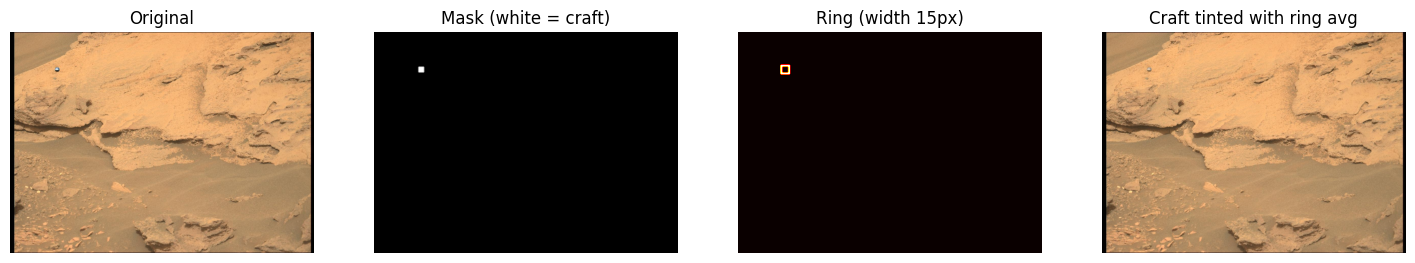

In [142]:
# Cell ▶  Replace craft pixels by the average colour of the *surrounding rim*
import random, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

ALPHA = 0.50                       # 1 → full flat colour, 0 → none
RING_WIDTH = 15                   # dilation kernel size (pixels)
ROOT = Path('split_dataset')      # adjust if needed

# ───────── pick random img & mask ─────────────────────────────────────────
splits = [s for s in ['train', 'val', 'test'] if (ROOT / s).exists()]
assert splits, "No split_dataset found."
split = random.choice(splits)

img_dir, mask_dir = ROOT / split / 'img', ROOT / split / 'mask'
img_path = random.choice([p for p in img_dir.glob('*') 
                          if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}])
mask_path = mask_dir / f'{img_path.stem}_mask.png'
if not mask_path.exists():
    mask_path = mask_dir / f'{img_path.stem}_mask{img_path.suffix}'
assert mask_path.exists(), f"Mask for {img_path.name} not found."

print(f"Using  {split}/{img_path.name}")

# ───────── read data ──────────────────────────────────────────────────────
img = cv2.imread(str(img_path))
msk = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

# ➟ boolean mask: True = craft/object
uap_mask = msk > np.percentile(msk, 50)          # minority as craft
if uap_mask.sum() > msk.size * 0.5:              # invert if majority
    uap_mask = ~uap_mask
print(f"Craft px: {uap_mask.sum()}  |  Total px: {msk.size}")

# ───────── build a thin "ring" around the object ─────────────────────────
kernel = np.ones((RING_WIDTH, RING_WIDTH), np.uint8)
dilated = cv2.dilate(uap_mask.astype(np.uint8), kernel, iterations=1).astype(bool)
ring_mask = dilated & (~uap_mask)
if ring_mask.sum() == 0:          # rare, e.g. object touches edges
    ring_mask = ~uap_mask         # fallback: whole background
print(f"Ring px: {ring_mask.sum()}")

# ───────── average colour of that ring ───────────────────────────────────
avg_bgr_ring = img[ring_mask].mean(axis=0).astype(np.uint8)
print("Average BGR of ring:", avg_bgr_ring)

# ───────── tint only the craft/object pixels ─────────────────────────────
tinted = img.astype(np.float32)
for c in range(3):
    channel = tinted[:, :, c]
    channel[uap_mask] = (1 - ALPHA) * channel[uap_mask] + ALPHA * avg_bgr_ring[c]
    tinted[:, :, c] = channel
tinted = np.clip(tinted, 0, 255).astype(np.uint8)

# ───────── visualise ──────────────────────────────────────────────────────
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original");          axs[0].axis('off')

axs[1].imshow(uap_mask, cmap='gray')
axs[1].set_title("Mask (white = craft)"); axs[1].axis('off')

axs[2].imshow(ring_mask, cmap='hot')
axs[2].set_title(f"Ring (width {RING_WIDTH}px)"); axs[2].axis('off')

axs[3].imshow(cv2.cvtColor(tinted, cv2.COLOR_BGR2RGB))
axs[3].set_title("Craft tinted with ring avg"); axs[3].axis('off')

plt.show()


In [143]:
"""
Tint each masked object with the average colour of the surrounding rim.

The folder layout must be:
split_dataset/
    train/
        img/            img_XXXX.jpg / .png …
        mask/           img_XXXX_mask.png (or same extension)
    val/
    test/

Original filenames are preserved – the edited image overwrites the source.
"""
from pathlib import Path
import cv2
import numpy as np

# ───────── PARAMETERS ────────────────────────────────────────────────────
ROOT        = Path("split_dataset")   # parent of train/val/test
ALPHA       = 0.50                    # 1 → full flat tint, 0 → no change
RING_WIDTH  = 15                      # dilation kernel size (pixels)
IMG_EXTS    = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}

# ───────── HELPER FUNCTIONS ──────────────────────────────────────────────
def get_mask_path(mask_dir: Path, stem: str) -> Path | None:
    """Return the mask file whose name starts with <stem>_mask.* ."""
    for p in mask_dir.iterdir():
        if p.stem.startswith(stem + "_mask"):
            return p
    return None

def tint_image(img_path: Path, mask_path: Path) -> None:
    """Apply tint to <img_path> in‑place using <mask_path>."""
    img = cv2.imread(str(img_path))
    msk = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    # Craft mask: minority class = foreground
    uap_mask = msk > np.percentile(msk, 50)
    if uap_mask.sum() > msk.size * 0.5:
        uap_mask = ~uap_mask

    # Build thin ring around the craft
    kernel  = np.ones((RING_WIDTH, RING_WIDTH), np.uint8)
    dilated = cv2.dilate(uap_mask.astype(np.uint8), kernel, iterations=1).astype(bool)
    ring    = dilated & (~uap_mask)
    if ring.sum() == 0:                      # fallback when object touches edge
        ring = ~uap_mask

    avg_bgr = img[ring].mean(axis=0)

    # Blend only craft pixels toward that colour
    tinted = img.astype(np.float32)
    for c in range(3):
        ch = tinted[:, :, c]
        ch[uap_mask] = (1 - ALPHA) * ch[uap_mask] + ALPHA * avg_bgr[c]
        tinted[:, :, c] = ch
    tinted = np.clip(tinted, 0, 255).astype(np.uint8)

    cv2.imwrite(str(img_path), tinted)       # overwrite

# ───────── MAIN LOOP ─────────────────────────────────────────────────────
splits = [s for s in ["train", "val", "test"] if (ROOT / s).exists()]
if not splits:
    raise SystemExit("No split_dataset directory found.")

for split in splits:
    img_dir  = ROOT / split / "img"
    mask_dir = ROOT / split / "mask"
    print(f"\n▶ Processing split '{split}'")

    img_files = [p for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS]
    if not img_files:
        print("  (no images found)")
        continue

    for idx, img_path in enumerate(sorted(img_files), 1):
        mask_path = get_mask_path(mask_dir, img_path.stem)
        if not mask_path:
            print(f"  [SKIP] mask for {img_path.name} not found")
            continue

        tint_image(img_path, mask_path)
        if idx % 50 == 0 or idx == len(img_files):
            print(f"  {idx}/{len(img_files)} images done", end="\r")

print("\nAll splits processed – images overwritten with tinted versions.")



▶ Processing split 'train'
  8624/8624 images done
▶ Processing split 'val'
  1078/1078 images done
▶ Processing split 'test'
  1078/1078 images done
All splits processed – images overwritten with tinted versions.


In [146]:
# %% [markdown]
# # Renumber dataset files so that indices are consecutive
# 
# **Folder layouts supported**
# 
# | Mode | Structure |
# |------|-----------|
# | `flat` | `dataset/{img, mask, annotations}/img_0001234.*` |
# | `split` | `dataset/{train,val,test}/{img,mask,annotations}/img_0001234.*` |
# 
# The script performs a **dry run first** (nothing is renamed).  
# Set `DRY_RUN = False` in the *Configuration* cell and rerun the *Execution* cell
# once you are happy with the preview.

# %%
# ─────────────────────────── 1. Configuration ────────────────────────────
from pathlib import Path

DATASET_ROOT = Path("uap_10k_mars_aug_dataset")   # change to "split_dataset" if needed
ROOT_MODE    = "split"            # "flat"  or  "split"
DRY_RUN      = False              # True = preview only; False = rename
PAD_LEN      = 7                 # img_0000001.png
IMG_EXTS     = {".png", ".jpg", ".jpeg"}

print(f"Root: {DATASET_ROOT.resolve()}\nMode: {ROOT_MODE}\nDry‑run: {DRY_RUN}")

# %%
# ─────────────────────── 2. Helper + Renumber logic ──────────────────────
import re, shutil, sys

def _parse_index(stem: str):
    """Return numeric part of 'img_0000123' or None."""
    m = re.match(r"img_(\d+)$", stem)
    return m.group(1) if m else None

def _find_triplets(img_dir: Path, mask_dir: Path, ann_dir: Path):
    """Yield (img, mask, ann) triples that all exist."""
    for img in sorted(img_dir.iterdir()):
        if img.suffix.lower() not in IMG_EXTS:
            continue
        if _parse_index(img.stem) is None:
            print(f"[WARN] Bad image name {img.name}; skipped.")
            continue

        mask = mask_dir / f"{img.stem}_mask{img.suffix}"
        if not mask.exists():                 # fallback to .png
            mask = mask_dir / f"{img.stem}_mask.png"
        ann  = ann_dir  / f"{img.stem}.txt"

        if mask.exists() and ann.exists():
            yield img, mask, ann
        else:
            print(f"[WARN] Missing pair for {img.name}")

def renumber_split(split_root: Path):
    img_dir, mask_dir, ann_dir = (split_root / "img",
                                  split_root / "mask",
                                  split_root / "annotations")
    if not all(d.exists() for d in (img_dir, mask_dir, ann_dir)):
        print(f"[SKIP] {split_root} lacks required sub‑folders"); return

    triples = list(_find_triplets(img_dir, mask_dir, ann_dir))
    if not triples:
        print(f"[INFO] No complete triples in {split_root}"); return

    print(f"\n▶ Processing '{split_root.relative_to(DATASET_ROOT)}' "
          f"({len(triples)} triples)")
    for new_idx, (img, mask, ann) in enumerate(triples, start=1):
        new_stem  = f"img_{new_idx:0{PAD_LEN}d}"
        targets = [
            (img,  img.with_name(new_stem + img.suffix)),
            (mask, mask.with_name(new_stem + "_mask" + mask.suffix)),
            (ann,  ann.with_name(new_stem + ".txt")),
        ]
        for src, dst in targets:
            if src == dst:
                continue
            action = "DRY‑RUN" if DRY_RUN else "RENAMED"
            print(f"{action:7}  {src.name} → {dst.name}")
            if not DRY_RUN:
                shutil.move(src, dst)

# %%
# ─────────────────────────── 3. Execution cell ───────────────────────────
if ROOT_MODE not in {"flat", "split"}:
    sys.exit("ROOT_MODE must be 'flat' or 'split'")

if ROOT_MODE == "flat":
    renumber_split(DATASET_ROOT)
else:                                   # split mode
    for split in ("train", "val", "test"):
        sp_root = DATASET_ROOT / split
        if sp_root.exists():
            renumber_split(sp_root)

print("\n✅ Pass finished.")
if DRY_RUN:
    print("Nothing was renamed (dry run). "
          "Set DRY_RUN = False and rerun to apply changes.")


Root: C:\Users\keplarV4\Downloads\Github\Graduate School\detect-uap-mars\dataset\uap_10k_mars_aug_dataset
Mode: split
Dry‑run: False

▶ Processing 'train' (8624 triples)
RENAMED  img_0000008.jpg → img_0000007.jpg
RENAMED  img_0000008_mask.png → img_0000007_mask.png
RENAMED  img_0000008.txt → img_0000007.txt
RENAMED  img_0000009.jpg → img_0000008.jpg
RENAMED  img_0000009_mask.png → img_0000008_mask.png
RENAMED  img_0000009.txt → img_0000008.txt
RENAMED  img_0000011.jpg → img_0000009.jpg
RENAMED  img_0000011_mask.png → img_0000009_mask.png
RENAMED  img_0000011.txt → img_0000009.txt
RENAMED  img_0000012.jpg → img_0000010.jpg
RENAMED  img_0000012_mask.png → img_0000010_mask.png
RENAMED  img_0000012.txt → img_0000010.txt
RENAMED  img_0000013.jpg → img_0000011.jpg
RENAMED  img_0000013_mask.png → img_0000011_mask.png
RENAMED  img_0000013.txt → img_0000011.txt
RENAMED  img_0000014.jpg → img_0000012.jpg
RENAMED  img_0000014_mask.png → img_0000012_mask.png
RENAMED  img_0000014.txt → img_0000012.